# Month 3 – Big Data Analytics for Real-time Traffic Congestion Detection (by Faiz Hussain)

In [ ]:
# Problem Statement:
# A smart city initiative wants to use real-time sensor data from roads to detect traffic congestion, predict bottlenecks, and optimize traffic lights.

In [ ]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("TrafficCongestionDetection") \
    .getOrCreate()

spark


In [2]:
# Load CSV into Spark
traffic_df = spark.read.csv("synthetic_traffic.csv", header=True, inferSchema=True)

# Show schema
traffic_df.printSchema()

# Show first 5 rows
traffic_df.show(5)


root
 |-- timestamp: timestamp (nullable = true)
 |-- intersection_id: string (nullable = true)
 |-- vehicles_count: integer (nullable = true)
 |-- avg_speed_kmph: double (nullable = true)
 |-- weather: string (nullable = true)
 |-- is_holiday: integer (nullable = true)

+-------------------+---------------+--------------+--------------+-------+----------+
|          timestamp|intersection_id|vehicles_count|avg_speed_kmph|weather|is_holiday|
+-------------------+---------------+--------------+--------------+-------+----------+
|2025-07-01 00:00:00|            J01|            37|          46.6|  clear|         0|
|2025-07-01 00:00:00|            J02|             5|          43.9|  storm|         0|
|2025-07-01 00:00:00|            J03|            35|          46.2|  clear|         0|
|2025-07-01 00:00:00|            J04|            26|          41.6|   rain|         0|
|2025-07-01 00:00:00|            J05|            38|          43.6|  clear|         0|
+-------------------+-----------

In [3]:
# Count rows
print("Total rows:", traffic_df.count())

# Check schema again
traffic_df.printSchema()

# Check for nulls per column
for col in traffic_df.columns:
    nulls = traffic_df.filter(traffic_df[col].isNull()).count()
    print(f"{col}: {nulls} null values")


Total rows: 24192
root
 |-- timestamp: timestamp (nullable = true)
 |-- intersection_id: string (nullable = true)
 |-- vehicles_count: integer (nullable = true)
 |-- avg_speed_kmph: double (nullable = true)
 |-- weather: string (nullable = true)
 |-- is_holiday: integer (nullable = true)

timestamp: 0 null values
intersection_id: 0 null values
vehicles_count: 0 null values
avg_speed_kmph: 0 null values
weather: 0 null values
is_holiday: 0 null values


In [6]:
from pyspark.sql.functions import to_timestamp, hour, col

# Convert timestamp column to proper type
traffic_df = traffic_df.withColumn(
    "timestamp", to_timestamp(col("timestamp"))
)

# Extract hour of day
traffic_df = traffic_df.withColumn("hour", hour(col("timestamp")))

# Show results
traffic_df.select("timestamp", "hour", "vehicles_count").show(5)


+-------------------+----+--------------+
|          timestamp|hour|vehicles_count|
+-------------------+----+--------------+
|2025-07-01 00:00:00|   0|            37|
|2025-07-01 00:00:00|   0|             5|
|2025-07-01 00:00:00|   0|            35|
|2025-07-01 00:00:00|   0|            26|
|2025-07-01 00:00:00|   0|            38|
+-------------------+----+--------------+
only showing top 5 rows


In [8]:
from pyspark.sql.functions import sum as spark_sum

# Group by intersection and hour
traffic_agg = traffic_df.groupBy("intersection_id", "hour") \
    .agg(spark_sum("vehicles_count").alias("total_vehicles")) \
    .orderBy("hour")

traffic_agg.show(10)


+---------------+----+--------------+
|intersection_id|hour|total_vehicles|
+---------------+----+--------------+
|            J08|   0|          2152|
|            J07|   0|          2290|
|            J10|   0|          2246|
|            J11|   0|          2093|
|            J01|   0|          2154|
|            J09|   0|          2220|
|            J03|   0|          2269|
|            J04|   0|          2154|
|            J12|   0|          2304|
|            J02|   0|          2040|
+---------------+----+--------------+
only showing top 10 rows


In [9]:
# Average vehicles per hour (across all intersections)
avg_per_hour = traffic_agg.groupBy("hour") \
    .avg("total_vehicles") \
    .orderBy("hour")

avg_per_hour.show()


+----+-------------------+
|hour|avg(total_vehicles)|
+----+-------------------+
|   0| 2189.9166666666665|
|   1| 2195.1666666666665|
|   2|            2321.25|
|   3|            2519.25|
|   4|            3007.25|
|   5| 3877.0833333333335|
|   6|  5071.416666666667|
|   7|  6558.416666666667|
|   8|  7683.583333333333|
|   9|            8213.75|
|  10|  7850.416666666667|
|  11|             6762.0|
|  12|            5414.25|
|  13|  4683.333333333333|
|  14|  4809.416666666667|
|  15|  5510.666666666667|
|  16|            6883.75|
|  17|  8014.083333333333|
|  18|  8504.333333333334|
|  19|  8156.166666666667|
+----+-------------------+
only showing top 20 rows


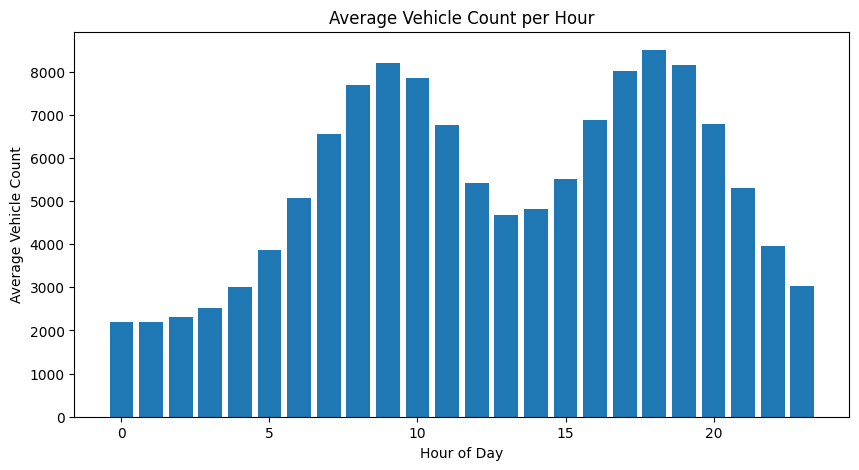

In [10]:
# Convert to Pandas for plotting
avg_hour_pd = avg_per_hour.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(avg_hour_pd['hour'], avg_hour_pd['avg(total_vehicles)'])
plt.title("Average Vehicle Count per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicle Count")
plt.show()


In [12]:
from pyspark.sql.functions import sum as spark_sum

# Group by intersection and hour
traffic_agg = traffic_df.groupBy("intersection_id", "hour") \
    .agg(spark_sum("vehicles_count").alias("total_vehicles")) \
    .orderBy("hour")

traffic_agg.show(10)


+---------------+----+--------------+
|intersection_id|hour|total_vehicles|
+---------------+----+--------------+
|            J08|   0|          2152|
|            J07|   0|          2290|
|            J10|   0|          2246|
|            J11|   0|          2093|
|            J01|   0|          2154|
|            J09|   0|          2220|
|            J03|   0|          2269|
|            J04|   0|          2154|
|            J12|   0|          2304|
|            J02|   0|          2040|
+---------------+----+--------------+
only showing top 10 rows


In [13]:
# Average vehicle count per hour across all intersections
avg_per_hour = traffic_agg.groupBy("hour") \
    .avg("total_vehicles") \
    .orderBy("hour")

avg_per_hour.show()


+----+-------------------+
|hour|avg(total_vehicles)|
+----+-------------------+
|   0| 2189.9166666666665|
|   1| 2195.1666666666665|
|   2|            2321.25|
|   3|            2519.25|
|   4|            3007.25|
|   5| 3877.0833333333335|
|   6|  5071.416666666667|
|   7|  6558.416666666667|
|   8|  7683.583333333333|
|   9|            8213.75|
|  10|  7850.416666666667|
|  11|             6762.0|
|  12|            5414.25|
|  13|  4683.333333333333|
|  14|  4809.416666666667|
|  15|  5510.666666666667|
|  16|            6883.75|
|  17|  8014.083333333333|
|  18|  8504.333333333334|
|  19|  8156.166666666667|
+----+-------------------+
only showing top 20 rows


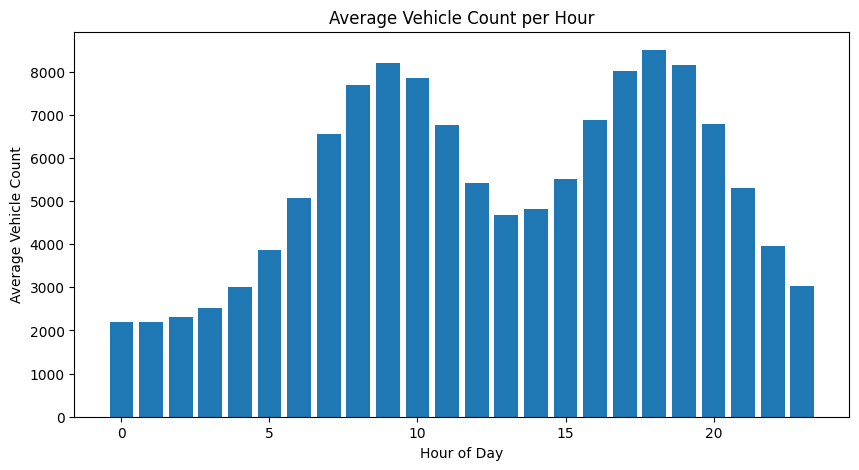

In [14]:
# Convert Spark DF to Pandas for plotting
avg_hour_pd = avg_per_hour.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(avg_hour_pd['hour'], avg_hour_pd['avg(total_vehicles)'])
plt.title("Average Vehicle Count per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicle Count")
plt.show()


In [15]:
# Total traffic per intersection
top_intersections = traffic_agg.groupBy("intersection_id") \
    .sum("total_vehicles") \
    .orderBy("sum(total_vehicles)", ascending=False)

top_intersections.show(10)


+---------------+-------------------+
|intersection_id|sum(total_vehicles)|
+---------------+-------------------+
|            J03|             130187|
|            J04|             130126|
|            J10|             129890|
|            J12|             129687|
|            J08|             129659|
|            J09|             129331|
|            J07|             129268|
|            J02|             129255|
|            J06|             128903|
|            J11|             128751|
+---------------+-------------------+
only showing top 10 rows


In [18]:
from pyspark.sql.functions import when

# Define congestion categories based on vehicle count
traffic_df = traffic_df.withColumn(
    "congestion_level",
    when(traffic_df.vehicles_count < 20, "Light")
    .when(traffic_df.vehicles_count < 50, "Medium")
    .otherwise("Heavy")
)

traffic_df.select("vehicles_count", "congestion_level").show(10)


+--------------+----------------+
|vehicles_count|congestion_level|
+--------------+----------------+
|            37|          Medium|
|             5|           Light|
|            35|          Medium|
|            26|          Medium|
|            38|          Medium|
|            35|          Medium|
|            29|          Medium|
|            45|          Medium|
|            29|          Medium|
|            24|          Medium|
+--------------+----------------+
only showing top 10 rows


In [20]:
# Select features and label
ml_df = traffic_df.select("vehicles_count", "hour", "congestion_level")
ml_df.show(5)


+--------------+----+----------------+
|vehicles_count|hour|congestion_level|
+--------------+----+----------------+
|            37|   0|          Medium|
|             5|   0|           Light|
|            35|   0|          Medium|
|            26|   0|          Medium|
|            38|   0|          Medium|
+--------------+----+----------------+
only showing top 5 rows


In [22]:
# Select features and label
ml_df = traffic_df.select("vehicles_count", "hour", "congestion_level")
ml_df.show(5)


+--------------+----+----------------+
|vehicles_count|hour|congestion_level|
+--------------+----+----------------+
|            37|   0|          Medium|
|             5|   0|           Light|
|            35|   0|          Medium|
|            26|   0|          Medium|
|            38|   0|          Medium|
+--------------+----+----------------+
only showing top 5 rows


In [24]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Convert labels into numeric index
label_indexer = StringIndexer(inputCol="congestion_level", outputCol="label")

# Assemble features into vector
assembler = VectorAssembler(
    inputCols=["vehicles_count", "hour"],
    outputCol="features"
)

pipeline = Pipeline(stages=[label_indexer, assembler])
final_df = pipeline.fit(ml_df).transform(ml_df)

final_df.select("features", "label").show(5)


+----------+-----+
|  features|label|
+----------+-----+
|[37.0,0.0]|  1.0|
| [5.0,0.0]|  2.0|
|[35.0,0.0]|  1.0|
|[26.0,0.0]|  1.0|
|[38.0,0.0]|  1.0|
+----------+-----+
only showing top 5 rows


In [25]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)


In [26]:
from pyspark.ml.classification import RandomForestClassifier

# Build model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)

# Train
rf_model = rf.fit(train_df)

# Predict
predictions = rf_model.transform(test_df)

predictions.select("features", "label", "prediction").show(10)


+----------+-----+----------+
|  features|label|prediction|
+----------+-----+----------+
| [3.0,1.0]|  2.0|       2.0|
| [4.0,0.0]|  2.0|       2.0|
| [4.0,1.0]|  2.0|       2.0|
| [4.0,2.0]|  2.0|       2.0|
| [5.0,0.0]|  2.0|       2.0|
| [5.0,0.0]|  2.0|       2.0|
| [5.0,2.0]|  2.0|       2.0|
|[5.0,22.0]|  2.0|       2.0|
| [6.0,1.0]|  2.0|       2.0|
| [6.0,1.0]|  2.0|       2.0|
+----------+-----+----------+
only showing top 10 rows


In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.9923204649232047


In [28]:
predictions.groupBy("label", "prediction").count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1470|
|  2.0|       2.0|  193|
|  1.0|       2.0|   37|
|  0.0|       0.0| 3118|
+-----+----------+-----+



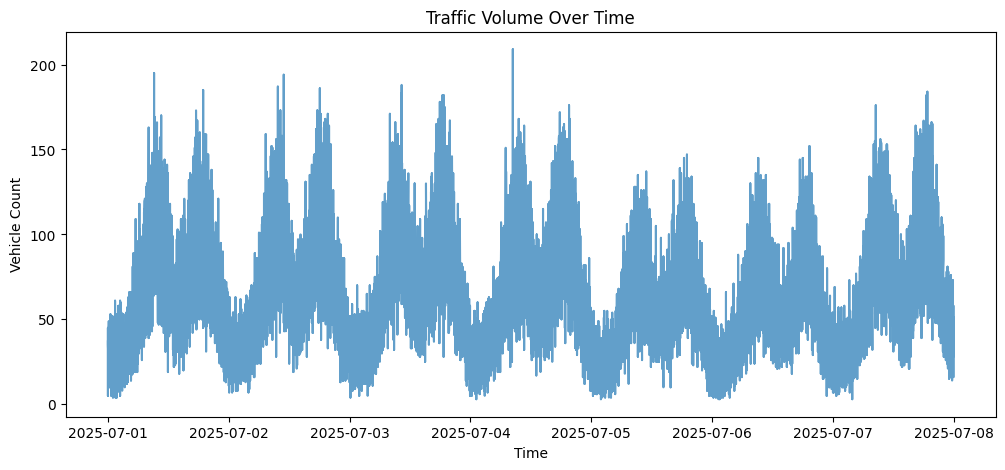

In [31]:
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
traffic_pd = traffic_df.select("timestamp", "vehicles_count").toPandas()

traffic_pd = traffic_pd.sort_values("timestamp")

plt.figure(figsize=(12,5))
plt.plot(traffic_pd["timestamp"], traffic_pd["vehicles_count"], alpha=0.7)
plt.title("Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Vehicle Count")
plt.show()


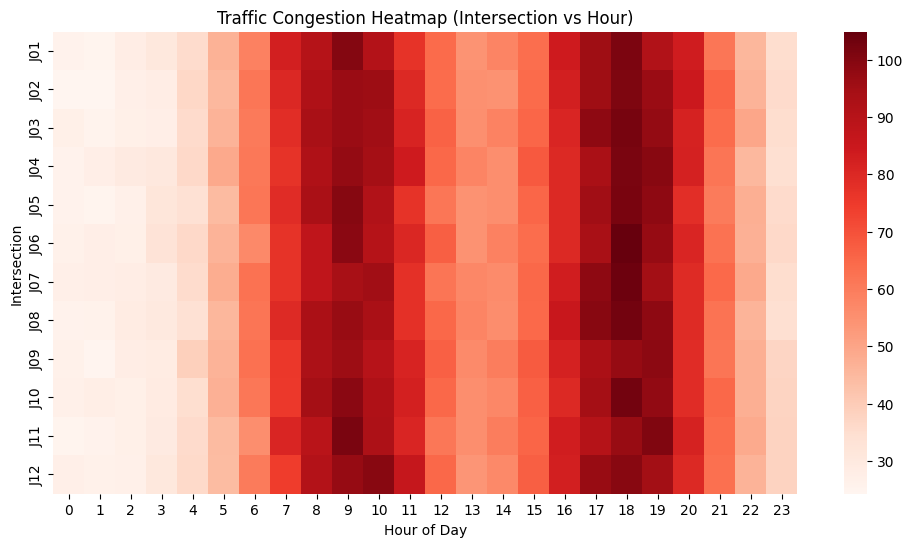

In [34]:
import seaborn as sns

# Convert aggregated Spark DF to Pandas
heatmap_pd = traffic_df.groupBy("intersection_id", "hour") \
    .avg("vehicles_count") \
    .toPandas()

# Pivot table for heatmap
heatmap_matrix = heatmap_pd.pivot(index="intersection_id", columns="hour", values="avg(vehicles_count)")

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_matrix, cmap="Reds")
plt.title("Traffic Congestion Heatmap (Intersection vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Intersection")
plt.show()


In [35]:
import time

# Simulated streaming loop
for batch in range(0, len(traffic_pd), 100):   # process 100 rows at a time
    chunk = traffic_pd.iloc[batch:batch+100]
    print(f"Processing batch {batch//100 + 1}")
    print(chunk.head(3))   # show preview
    
    time.sleep(1)  # wait to simulate real-time


Processing batch 1
    timestamp  vehicles_count
0  2025-07-01              37
11 2025-07-01              19
10 2025-07-01              23
Processing batch 2
              timestamp  vehicles_count
99  2025-07-01 00:40:00               5
100 2025-07-01 00:40:00              20
101 2025-07-01 00:40:00              33
Processing batch 3
              timestamp  vehicles_count
200 2025-07-01 01:20:00              24
201 2025-07-01 01:20:00              18
202 2025-07-01 01:20:00              21
Processing batch 4
              timestamp  vehicles_count
311 2025-07-01 02:05:00              26
310 2025-07-01 02:05:00              27
309 2025-07-01 02:05:00              26
Processing batch 5
              timestamp  vehicles_count
403 2025-07-01 02:45:00              36
402 2025-07-01 02:45:00              13
401 2025-07-01 02:45:00              10
Processing batch 6
              timestamp  vehicles_count
494 2025-07-01 03:25:00              19
493 2025-07-01 03:25:00              31
492 20